In [1]:
from lib.dataloader import get_MNIST_loaders
from lib.models import SNN, LoRA_SNN
from lib.train import train
from lib.visualize import plot_losses, plot_accs
from lib.test import test, test_ICL, test_single_class
from lib.save import save
from lib.parameters_info import count_all_parameters, count_lora_parameters

import os

import torch
import torch.nn as nn


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [4]:
path = os.path.dirname(os.path.abspath("__file__"))

data_path = path + "\\data"
model_path = path + f"\\SNN_LoRA/ICL_state_dict_task_{1}.pth"

## Get MNIST

In [5]:
# Get data for task 2
task_names = []
train_loaders, val_loaders, test_loaders = [], [], []
for i in range(10) :
    task_names.append("task_"+str(i+1))
    class_name = [i]
    train_loader, val_loader, test_loader = get_MNIST_loaders(data_path, class_name, batch_size)
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
    test_loaders.append(test_loader)

## Train vanilla SNN on task 1

In [6]:
task = task_names[0]
train_loader = train_loaders[0]
val_loader = val_loaders[0]

In [7]:
snn_model = SNN(num_inputs, num_hidden, num_outputs, beta, num_steps).to(device)

In [8]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn_model.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 1

In [9]:
output = train(snn_model, task, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device, comp_val_loader=None)
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = output

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


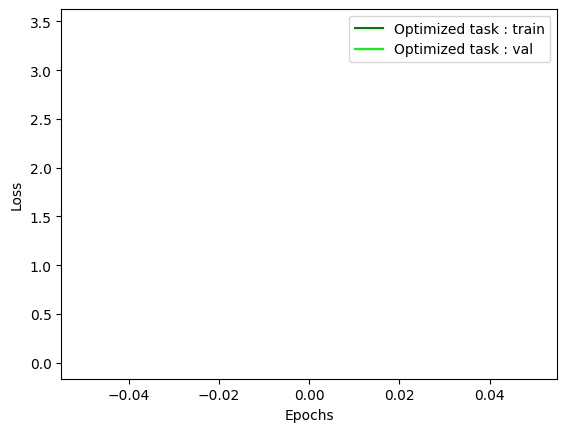

In [10]:
plot_losses(train_loss_hist, val_loss_hist)

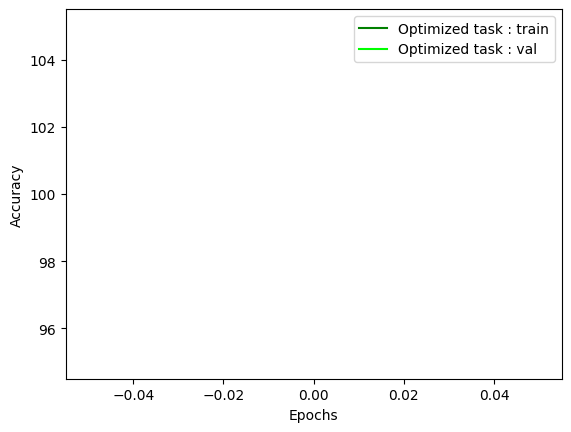

In [11]:
plot_accs(train_acc_hist, val_acc_hist)

## Test SNN on task 1

In [12]:
print(f"model achieves {test_ICL(snn_model, test_loaders[:1], batch_size, device)}% accuracy on task 1")

model achieves 100.0% accuracy on task 1


## Save vanilla SNN

In [13]:
save(model_path, snn_model)

## Train LoRA SNN on tasks 2 to 10

Deux possibilités :

    - Soit on a 10 output neurones dès l'entrainement sur la première tache
    - Soit on ajoute un output neurone pour chaque nonuvelle tache

In [14]:
lora_rank = 4
num_epochs = 1

In [15]:
import numpy as np

In [16]:
test_accs_matrix = []
mean_test_accs_through_past_tasks = []
for i in range(1,10) :
    lora_snn_model = LoRA_SNN(lora_rank, model_path, num_inputs, num_hidden, num_outputs, beta, batch_size, num_steps).to(device)
    print("Number of none LoRA parameters of the linear layers (not trainable):", count_all_parameters(lora_snn_model))
    if i == 1 :
        print("Number of parameters introduced by LoRA (trainable):", count_lora_parameters(lora_snn_model))
    
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test_single_class(lora_snn_model, test_loaders[j], batch_size, device)
        test_accs[j] = test_acc
    test_accs_matrix.append(test_accs)
    mean_test_accs_through_past_tasks.append(np.mean(test_accs[:i]))
    
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lora_snn_model.parameters(), lr=3e-4, betas=(0.5, 0.999))

    task = task_names[i]
    train_loader = train_loaders[i]
    val_loader = val_loaders[i]

    _ = train(lora_snn_model, task, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device)
    
    #test_acc = test_ICL(lora_snn_model, [test_loaders[0]], None, batch_size, device)
    #test_accs.append(test_acc)
    #print(f"model achieves {test_acc}% accuracy on task_1 to ", task_names[i])
    
    fc1_update = lora_snn_model.model.fc1.weight + 1.8*torch.mm(lora_snn_model.l1_lora_A, lora_snn_model.l1_lora_B).T
    lora_snn_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_snn_model.model.fc2.weight + 1.8*torch.mm(lora_snn_model.l2_lora_A, lora_snn_model.l2_lora_B).T
    lora_snn_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    save(model_path, lora_snn_model.model)

test_accs = np.zeros(10)
for j in range(10) :
    test_acc = test_single_class(lora_snn_model, test_loaders[j], batch_size, device)
    test_accs[j] = test_acc
test_accs_matrix.append(test_accs)
mean_test_accs_through_past_tasks.append(np.mean(test_accs[:10]))

Number of none LoRA parameters of the linear layers (not trainable): 795010
Number of parameters introduced by LoRA (trainable): 11176


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

batch 0 :  tensor([[ 553.1168, -181.6923, -251.9877, -211.2031, -150.0779, -278.0764,
         -227.8359, -149.9500, -158.7617, -195.9678],
        [ 505.3797, -151.8182, -182.6952, -215.4384, -146.0979, -234.6087,
         -242.8897, -167.8114, -117.5689, -177.7896]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  819.6481323242188
batch 30 : tensor([[  20.6508,  262.7489, -480.1005, -488.6736, -532.8731, -532.1381,
         -623.5577, -525.8763, -455.4195, -504.1488],
        [  30.0917,   89.4675, -416.4063, -388.7985, -318.1499, -391.0435,
         -445.2957, -397.9520, -355.6030, -376.6635]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  18.43140411376953


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Number of none LoRA parameters of the linear layers (not trainable): 795010


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

batch 0 :  tensor([[ 616.8398,  -47.2157, -585.9086, -502.7673, -532.8675, -550.1228,
         -523.9068, -541.6124, -495.0474, -458.8869],
        [ 482.3563,   16.2036, -482.4991, -447.9241, -474.4658, -464.1795,
         -505.5158, -479.2821, -421.1459, -481.2932]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  1403.690185546875
batch 30 : tensor([[  21.7405, -172.7163,   70.1176, -894.2588, -869.4884, -892.8640,
         -873.0221, -791.9163, -774.9802, -814.5799],
        [ 646.2841, -973.6588,  112.5913, -635.0403, -657.3040, -689.2435,
         -659.7541, -595.8152, -594.2928, -577.4877]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  189.22064208984375


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Number of none LoRA parameters of the linear layers (not trainable): 795010


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

batch 0 :  tensor([[ -828.6423,    29.1133,   141.3860, -1106.5406, -1077.9543, -1147.7106,
         -1184.9921, -1122.9211, -1080.4479, -1041.8229],
        [ -140.9428,  -284.9612,   328.2597,  -868.8474,  -766.2549,  -883.5967,
          -852.5249,  -787.9214,  -726.6599,  -812.3379]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  1044.395263671875
batch 30 : tensor([[  31.1518, -292.6931, -638.2562,  173.9807, -612.5119, -738.4395,
         -689.5966, -603.6722, -722.3928, -701.4910],
        [-509.5020, -366.3482,   52.9143, -218.1743, -901.1412, -919.7189,
         -986.8430, -885.4833, -857.9674, -815.4606]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  45.509056091308594


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Number of none LoRA parameters of the linear layers (not trainable): 795010


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

batch 0 :  tensor([[ -329.8286,  -295.3377,  -295.5513,   128.3867,  -643.5325,  -698.1037,
          -715.7460,  -676.4928,  -662.8713,  -603.7300],
        [ -873.9219,    -6.9910,    14.6811,  -177.7472,  -830.4315,  -935.5507,
         -1017.4124,  -929.4401,  -864.2023,  -853.3251]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  978.115966796875
batch 30 : tensor([[-839.8453,  -33.4441, -228.0582, -163.3928, -219.0178, -774.2932,
         -833.0499, -759.2386, -731.4778, -729.3817],
        [  27.0871, -710.0123, -154.4255, -412.4930,  659.9457, -389.8754,
         -434.2753, -316.6772, -271.9186, -327.1381]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  69.72492218017578


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Number of none LoRA parameters of the linear layers (not trainable): 795010


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

batch 0 :  tensor([[ 313.5238, -657.2599, -216.4832, -808.1428,  251.5763, -565.0385,
         -627.2168, -504.4473, -526.2034, -506.9272],
        [  22.9883, -428.0374, -717.4050,  120.4776,   13.3115, -586.2812,
         -672.9135, -599.2701, -581.7454, -569.5933]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  903.3414306640625


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.87s/it]


Number of none LoRA parameters of the linear layers (not trainable): 795010


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

batch 0 :  tensor([[  98.4482, -598.2836, -656.7857, -451.0381, -492.3596,   30.2801,
         -757.3575, -722.4482, -709.4638, -696.7563],
        [  11.1285, -420.8541, -471.9556, -433.2941,  147.8506,  214.5467,
         -351.7892, -298.7258, -335.0433, -349.2236]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  841.012451171875
batch 30 : tensor([[  33.5121, -523.8156, -449.8514, -368.4577,   14.5935,  143.9538,
          209.8574, -162.0408, -268.1524, -170.4439],
        [-112.8690, -594.4244, -175.4387, -415.2686,  -16.4110, -290.9614,
          404.5031, -326.0094, -405.6796, -366.5146]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  67.03343200683594


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Number of none LoRA parameters of the linear layers (not trainable): 795010


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

batch 0 :  tensor([[-630.5188, -380.6805, -262.8041, -196.9631, -749.0726, -114.4196,
         -464.4050, -799.7357, -774.6302, -636.3717],
        [-110.9931, -639.4712, -311.1906, -411.8945, -276.7291, -386.7054,
           68.0101, -547.5988, -627.8396, -547.8120]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  669.0931396484375
batch 30 : tensor([[  13.4280, -485.9474, -523.5225, -188.1590, -335.0548, -161.0282,
          127.3883,  -43.1293, -424.1157, -370.4383],
        [-177.1589, -388.4702, -273.7367, -602.9695,  151.7831,  -13.7885,
           19.4052,  520.9133, -140.2489, -161.1190]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  36.600074768066406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Number of none LoRA parameters of the linear layers (not trainable): 795010


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

batch 0 :  tensor([[-344.5247, -520.2397, -538.8909, -333.5535, -478.6786, -370.5172,
           27.9660,  -40.0534, -687.6033, -571.8702],
        [-551.3943, -381.1834, -367.0575, -826.1122, -447.4147,  -96.5999,
          -80.0427, -320.1596, -743.2426, -688.9113]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  670.0073852539062
batch 30 : tensor([[ -84.9544, -321.7692, -310.2144, -281.4776, -392.8677,   30.1235,
         -331.4248, -191.9645,  394.1263, -253.1042],
        [-284.1788, -290.0753, -456.0765, -643.1405, -195.2869,  -81.2807,
           30.4831, -119.3646,   22.5031, -426.0045]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  47.765357971191406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Number of none LoRA parameters of the linear layers (not trainable): 795010


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

batch 0 :  tensor([[-196.8741, -661.4979, -447.1780, -106.9747,   26.5026,  -97.8285,
          -54.4131,  -23.9761,   33.4040, -306.1224],
        [-334.0004, -756.0984, -383.6487,    5.2122, -349.8684, -743.9404,
          -35.1808, -302.0061, -251.1441, -594.0267]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  511.9332580566406
batch 30 : tensor([[-240.9892, -181.0321, -414.6318, -449.1740, -152.8834,  -20.7991,
         -136.6491, -154.8297,   23.9650,  327.6627],
        [-266.3546, -236.9200, -605.4985, -389.2765, -304.5079,   13.4315,
          -56.0395,  -26.1540,   14.4129,   69.5981]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  28.150442123413086


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


## Visualize results

In [17]:
import matplotlib.pyplot as plt

Métrique aglomérante comme la moyenne n'est pas satisfaisante : on préfère (60,60,60) à (0,80,100) voire à (0,100,100)

On peut vouloir faire une HPO de sorte à ce qu'à chaque nouvelle tâche, on obtienne la même accuracy sur toutes les tâches précédentes.

Bon, mais si on fait une telle HPO, ya de bonnes chances qu'on n'arrive pas à avoir une accuracy constante à travers les tâches précédentes à chaque tâche qu'on ajoute.

Donc on peut vouloir ajouter un hyper paramètre $\mu_i$ par tâche $i$ qu'on ajoute et :
- Faire une seule big HPO où on optimise $\mu_2,...,\mu_9$ en même temps
- Ou faire une HPO pour trouver la meilleure valeur de $\mu_2$, puis d'autres HPO pour trouver la meilleure valeur de $\mu_i$, sachant la valeur optimale des $\mu_2,...,\mu_{i-1}$. 

La seconde appoche est  greedy, mais on a plus confiance en cette seconde façon de faire... Genre ouais ya de bonnes chances que ça marche mieux que la première approche parce que l'espace de recherche de la première approche est très grand (et donc en plus ce serait très couteux de mettre en place cette première approche)

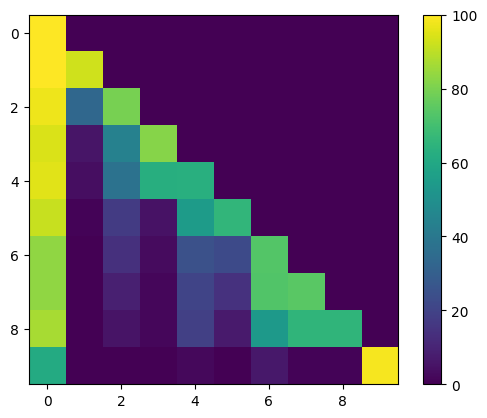

In [18]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to show the scale
plt.show()

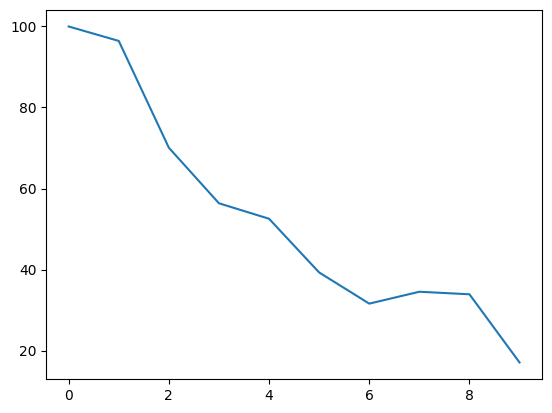

In [19]:
plt.plot(mean_test_accs_through_past_tasks)
plt.show()

Hyper parameters :
- (Variable) lora_rank
- (Variable) num_epochs
- (Variable) le scalaire 1.8
- (Variable) lr

HP sympas :
- lora_rank = 8
- num_epochs = 1
- le scalaire = 1.8
- lr = 2e-4

Idées :
- On ne peut pas demander d'identifier la tâche à résoudre parce que ça revient à résoudre notre problème
- Bon, mais on peut quand même vouloir faire une sorte d'ensemble learning, éventuellement pondérée par avec un meta-modèle qui dit la confiance qu'on doit avoir en chaque bout de modèle spécialisé sur chaque tâche (c'est que fait mixture of expert ?)
- 

## HPO

In [6]:
import optuna
from functools import partial
import numpy as np

In [9]:
def define_model(trial, params) :
    lora_rank = trial.suggest_int("lora_rank", 2, 8)
    alpha = trial.suggest_float("alpha", 0.5, 2)
    
    model_path, num_inputs, num_hidden, num_outputs, beta, batch_size, num_steps = params
    lora_snn_model = LoRA_SNN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs, 
                              beta, 
                              batch_size, 
                              num_steps)

    return lora_snn_model

def objective(params, device, trial) :
    # Define model
    lora_snn_model = define_model(trial, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 1e-5, 1e-4)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size, num_steps = params[-2:]
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lora_snn_model.parameters(), lr=lr)
    
    task = task_names[1]
    train_loader = train_loaders[1]
    val_loader = val_loaders[1]

    _ = train(lora_snn_model, task, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device)
    
    # Test
    test_accs = np.zeros(2)
    for j in range(2) :
        test_acc = test_single_class(lora_snn_model, test_loaders[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu - sigma
    
    return score

In [8]:
storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(storage=storage,
                            study_name="The Search",
                            #sampler=
                            direction = "maximize")
params = model_path, num_inputs, num_hidden, num_outputs, beta, batch_size, num_steps
partial_objective = partial(objective, params, device)
study.optimize(partial_objective,
               n_trials=20,
               timeout=3600)

pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Stats")
print("Number of finished trials : ", len(study.trials))
print("Number of pruned trials : ", len(pruned_trials))
print("Number of complete trials : ", len(complete_trials))

print("Best Trial")
best_trial = study.best_trial

print(" value : ", best_trial.value)

print("Params : ")
for key, value in best_trial.params.items():
    print("{} : {}".format(key, value))

[I 2024-04-23 10:04:18,035] A new study created in memory with name: The Search
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.51s/it]
[I 2024-04-23 10:04:27,548] Trial 0 finished with value: 99.10999999999999 and parameters: {'lora_rank': 10, 'alpha': 1.9811783179764315, 'lr': 0.0002951881355292313, 'num_epochs': 2}. Best is trial 0 with value: 99.10999999999999.
 33%|████████████████████████████                                                        | 1/3 [00:05<00:11,  5.56s/it]
[W 2024-04-23 10:04:33,147] Trial 1 failed with parameters: {'lora_rank': 14, 'alpha': 0.7178005836581814, 'lr': 4.112358695028514e-05, 'num_epochs': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\users\mathis\appdata\local\programs\python\python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Mathis\AppData\Local\T

KeyboardInterrupt: 

In [ ]:
def check_best_HPs (best_trial) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_snn_model = LoRA_SNN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs, 
                              beta, 
                              batch_size, 
                              num_steps).to(device)

    # Train
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lora_snn_model.parameters(), lr=lr)
    
    task = task_names[1]
    train_loader = train_loaders[1]
    val_loader = val_loaders[1]

    _ = train(lora_snn_model, task, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device)
    
    # Test
    test_accs = np.zeros(2)
    for j in range(2) :
        test_acc = test_single_class(lora_snn_model, test_loaders[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu - sigma
    
    return score, test_accs

In [28]:
check_best_HPs(best_trial)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

batch 0 :  tensor([[-703.0628, -244.9270, -633.5167, -691.9958, -201.1470, -264.6354,
            2.5325, -293.6506, -196.1639, -208.9483],
        [-165.9378, -129.2617, -476.2212, -305.8744,   41.1190,   18.9079,
          -57.4551, -120.3065,    5.4757,  203.7842]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  352.8072814941406
batch 30 : tensor([[-587.6716,   16.8398, -565.6735, -567.3915, -258.6596, -699.6704,
         -311.8998, -182.7981,  -69.0080, -340.9341],
        [-799.9741,   20.4159, -787.4398, -645.9930, -430.1458, -577.4514,
         -251.4719, -656.5274, -398.7877, -437.9829]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  98.70612335205078


 25%|█████████████████████                                                               | 1/4 [00:06<00:19,  6.54s/it]

batch 0 :  tensor([[-489.5389,  -86.9089, -740.9786, -405.9301, -138.5038,  -48.0920,
         -304.7424,   13.2310, -298.8629, -111.8397],
        [-766.2164,  -61.9961, -507.7692, -419.4381, -763.3883, -437.9068,
         -414.7191, -846.9468, -558.2440, -134.4226]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  66.44796752929688
batch 30 : tensor([[ -725.2620,    14.0802,  -693.3079,  -699.8192,  -361.3232,  -197.2377,
          -269.8948,  -753.3214,  -570.9106,   -98.0662],
        [ -785.6290,   -32.9070,  -294.5553,  -561.8040,  -949.2836,  -609.9510,
          -908.0195, -1193.0830,  -559.3129,  -350.0297]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  9.422932624816895


 50%|██████████████████████████████████████████                                          | 2/4 [00:13<00:14,  7.03s/it]

batch 0 :  tensor([[-531.1177,    3.1749, -633.8405, -393.6323, -354.0144, -345.0098,
         -213.0818, -347.8758, -575.2874, -112.7182],
        [-931.4888,   15.1583, -960.4493, -654.2486, -789.0201, -439.4452,
         -435.9659, -962.8973, -812.4395, -512.9714]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  9.649352073669434
batch 30 : tensor([[-800.2501,   95.1861, -916.2148, -849.1672, -524.1962, -826.1476,
         -502.8989, -340.0676, -345.6732, -655.1755],
        [-740.1047,   30.7340, -500.1870, -539.3529, -633.2587, -601.7153,
         -556.1063, -838.8849, -548.3705, -130.6185]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  3.4938206672668457


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:20<00:06,  6.76s/it]

batch 0 :  tensor([[ -777.7090,    87.2183,  -691.9231,  -636.4862,  -551.9847,  -532.2319,
          -589.4560,  -878.6042,  -610.8441,  -230.2353],
        [-1061.3452,    26.9754,  -362.9680,  -749.1033, -1107.6587, -1086.5012,
          -940.5648, -1124.8011,  -451.8015,  -389.3011]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 0 :  2.1449053287506104
batch 30 : tensor([[ -754.1155,    52.0481,  -977.8524,  -498.6024,  -346.1083,  -647.1819,
          -513.1225,  -205.7431,  -377.4735,  -566.9666],
        [ -931.6230,    31.6641, -1010.5192,  -938.0890,  -588.6284,  -598.4462,
          -355.5514,  -620.7384,  -658.1602,  -537.5921]], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss_val at batch 30 :  9.62514877319336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.66s/it]


(94.42, array([94.42, 95.8 ]))

## Greedy HPO

In [11]:
import optuna
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def define_model(trial, model_path, params) :
    lora_rank = trial.suggest_int("lora_rank", 8, 16)
    alpha = trial.suggest_float("alpha", 0.5, 2)
    
    num_inputs, num_hidden, num_outputs, beta, batch_size, num_steps = params
    lora_snn_model = LoRA_SNN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs, 
                              beta, 
                              batch_size, 
                              num_steps)

    return lora_snn_model

def objective(task_number, model_path, params, device, trial) :
    # Define model
    lora_snn_model = define_model(trial, model_path, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 1e-5, 5e-4)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size, num_steps = params[-2:]
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lora_snn_model.parameters(), lr=lr)
    
    task = task_names[task_number]
    train_loader = train_loaders[task_number]
    val_loader = val_loaders[task_number]

    _ = train(lora_snn_model, task, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device)
    
    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test_single_class(lora_snn_model, test_loaders[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu - sigma
    
    return score

In [13]:
def retrain_and_save_with_best_HPs (best_trial, i, model_path) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_snn_model = LoRA_SNN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs, 
                              beta, 
                              batch_size, 
                              num_steps).to(device)

    # Train
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lora_snn_model.parameters(), lr=lr)
    
    task = task_names[i]
    train_loader = train_loaders[i]
    val_loader = val_loaders[i]

    _ = train(lora_snn_model, task, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device)
    
    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test_single_class(lora_snn_model, test_loaders[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Save model
    fc1_update = lora_snn_model.model.fc1.weight + alpha*torch.mm(lora_snn_model.l1_lora_A, lora_snn_model.l1_lora_B).T
    lora_snn_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_snn_model.model.fc2.weight + alpha*torch.mm(lora_snn_model.l2_lora_A, lora_snn_model.l2_lora_B).T
    lora_snn_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    model_path = path + f"\\SNN_LoRA/ICL_state_dict_task_{i+1}.pth"
    save(model_path, lora_snn_model.model)
    
    return test_accs

In [14]:
# Compute scores of the model trained on the first task
model_path = path + f"\\SNN_LoRA/ICL_state_dict_task_{1}.pth"

lora_rank = 4 # The value of this parameters has no influence
alpha = 1.8 # The value of this parameter has no influence

lora_snn_model = LoRA_SNN(lora_rank,
                          alpha, 
                          model_path, 
                          num_inputs, 
                          num_hidden, 
                          num_outputs, 
                          beta, 
                          batch_size, 
                          num_steps).to(device)

test_accs = np.zeros(10)
test_acc = test_single_class(lora_snn_model, test_loaders[0], batch_size, device)
test_accs[0] = test_acc

# Initialize variable to store the best HPs and the scores
best_params = []
scores = [test_acc]
test_accs_matrix = [test_accs]
mean_test_accs_through_past_tasks = [test_acc]

for i in range(1,10) :
    print(f"Learning Task {i+1}")
    # Perform HPO
    storage = optuna.storages.InMemoryStorage()
    study = optuna.create_study(storage=storage,
                                study_name="The Search",
                                #sampler=
                                direction = "maximize")
    
    params = num_inputs, num_hidden, num_outputs, beta, batch_size, num_steps
    partial_objective = partial(objective, i, model_path, params, device)
    study.optimize(partial_objective,
                   n_trials=15,
                   timeout=3600)

    # Retrain and save a model with the best params
    best_trial = study.best_trial
    best_params.append(best_trial.params)
    test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
    
    model_path = path + f"\\SNN_LoRA/ICL_state_dict_task_{i+1}.pth"
    
    # Compute and store scores
    mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
    score = mu - sigma
    
    scores.append(score)
    test_accs_matrix.append(test_accs)
    mean_test_accs_through_past_tasks.append(mu)

[I 2024-04-23 10:05:22,948] A new study created in memory with name: The Search


Learning Task 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.47s/it]
[I 2024-04-23 10:05:30,809] Trial 0 finished with value: 94.04000000000002 and parameters: {'lora_rank': 12, 'alpha': 0.5462169936172134, 'lr': 0.00015283467537367213, 'num_epochs': 2}. Best is trial 0 with value: 94.04000000000002.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/it]
[I 2024-04-23 10:05:35,351] Trial 1 finished with value: 99.41 and parameters: {'lora_rank': 13, 'alpha': 1.8486223371226977, 'lr': 0.0002851532895118302, 'num_epochs': 1}. Best is trial 1 with value: 99.41.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.51s/it]
[I 2024-04-23 10:05:46,868] Trial 2 finished with value: 98.77 and parameters: {'lora_rank': 13, 'alpha': 1.7578872796197607, 'lr': 0.00023321870478525966, 'num_epochs': 3}. Best is trial 1 with valu

Learning Task 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.99s/it]
[I 2024-04-23 10:08:19,100] Trial 0 finished with value: -2.2601537063081523 and parameters: {'lora_rank': 13, 'alpha': 1.631342142361107, 'lr': 0.000348437207541979, 'num_epochs': 3}. Best is trial 0 with value: -2.2601537063081523.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.40s/it]
[I 2024-04-23 10:08:34,403] Trial 1 finished with value: -6.293952175699857 and parameters: {'lora_rank': 10, 'alpha': 1.6934261869555591, 'lr': 0.0003887580841427696, 'num_epochs': 4}. Best is trial 0 with value: -2.2601537063081523.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.25s/it]
[I 2024-04-23 10:08:42,454] Trial 2 finished with value: -12.171998737591075 and parameters: {'lora_rank': 16, 'alpha': 1.7667504109794525, 'lr': 0.00045926596655666965, '

Learning Task 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.87s/it]
[I 2024-04-23 10:11:14,223] Trial 0 finished with value: -12.486065133009959 and parameters: {'lora_rank': 14, 'alpha': 1.2512848479654985, 'lr': 0.00046987928342652274, 'num_epochs': 3}. Best is trial 0 with value: -12.486065133009959.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]
[I 2024-04-23 10:11:21,738] Trial 1 finished with value: 11.137755256318066 and parameters: {'lora_rank': 10, 'alpha': 1.3791628947037433, 'lr': 0.00020903657890631076, 'num_epochs': 2}. Best is trial 1 with value: 11.137755256318066.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.82s/it]
[I 2024-04-23 10:11:29,142] Trial 2 finished with value: -13.183709613745908 and parameters: {'lora_rank': 8, 'alpha': 1.4424836500580798, 'lr': 0.00045642601015739463,

Learning Task 5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]
[I 2024-04-23 10:13:04,761] Trial 0 finished with value: 47.95861757830573 and parameters: {'lora_rank': 15, 'alpha': 0.7532656227617753, 'lr': 6.082933461603226e-05, 'num_epochs': 4}. Best is trial 0 with value: 47.95861757830573.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]
[I 2024-04-23 10:13:09,417] Trial 1 finished with value: -14.50270341561027 and parameters: {'lora_rank': 14, 'alpha': 0.6732479673949583, 'lr': 0.00040857847045744193, 'num_epochs': 2}. Best is trial 0 with value: 47.95861757830573.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.65s/it]
[I 2024-04-23 10:13:15,564] Trial 2 finished with value: 27.769980405884954 and parameters: {'lora_rank': 11, 'alpha': 1.2130492026348163, 'lr': 0.00015563160438955865, 'num_

Learning Task 6


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/it]
[I 2024-04-23 10:14:41,226] Trial 0 finished with value: -20.466621298921734 and parameters: {'lora_rank': 13, 'alpha': 1.62427838657286, 'lr': 0.0003673800179925103, 'num_epochs': 4}. Best is trial 0 with value: -20.466621298921734.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]
[I 2024-04-23 10:14:44,216] Trial 1 finished with value: 2.1343560109618878 and parameters: {'lora_rank': 16, 'alpha': 0.8361666711725411, 'lr': 0.00034361553299081036, 'num_epochs': 1}. Best is trial 1 with value: 2.1343560109618878.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]
[I 2024-04-23 10:14:47,314] Trial 2 finished with value: -8.114742060572421 and parameters: {'lora_rank': 11, 'alpha': 1.032599995764972, 'lr': 0.00044682799432160174, 'nu

Learning Task 7


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]
[I 2024-04-23 10:16:03,862] Trial 0 finished with value: 2.253035469954014 and parameters: {'lora_rank': 9, 'alpha': 1.3234473045901005, 'lr': 0.00014507357634814782, 'num_epochs': 2}. Best is trial 0 with value: 2.253035469954014.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.78s/it]
[I 2024-04-23 10:16:10,962] Trial 1 finished with value: -16.784902246643306 and parameters: {'lora_rank': 14, 'alpha': 0.8516711718504495, 'lr': 0.000326004656711323, 'num_epochs': 3}. Best is trial 0 with value: 2.253035469954014.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]
[I 2024-04-23 10:16:14,364] Trial 2 finished with value: -16.280826140705948 and parameters: {'lora_rank': 16, 'alpha': 1.3717097780644125, 'lr': 0.00042581028587369217, 'num_

Learning Task 8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]
[I 2024-04-23 10:17:32,407] Trial 0 finished with value: 22.812528464725606 and parameters: {'lora_rank': 16, 'alpha': 1.6426525020762197, 'lr': 0.00011549582612068879, 'num_epochs': 1}. Best is trial 0 with value: 22.812528464725606.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]
[I 2024-04-23 10:17:36,106] Trial 1 finished with value: 19.7934117514582 and parameters: {'lora_rank': 8, 'alpha': 1.948329035411585, 'lr': 0.0001460327311258209, 'num_epochs': 1}. Best is trial 0 with value: 22.812528464725606.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]
[I 2024-04-23 10:17:39,862] Trial 2 finished with value: 11.494763487974009 and parameters: {'lora_rank': 16, 'alpha': 0.5961935904915403, 'lr': 0.0002864084307931497, 'num_ep

Learning Task 9


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/it]
[I 2024-04-23 10:18:59,680] Trial 0 finished with value: -17.014696556501864 and parameters: {'lora_rank': 13, 'alpha': 0.5496550841691474, 'lr': 0.00040252648727825404, 'num_epochs': 2}. Best is trial 0 with value: -17.014696556501864.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]
[I 2024-04-23 10:19:05,179] Trial 1 finished with value: -12.037606385328885 and parameters: {'lora_rank': 15, 'alpha': 1.9886237917922127, 'lr': 0.00012296131890336304, 'num_epochs': 2}. Best is trial 1 with value: -12.037606385328885.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]
[I 2024-04-23 10:19:09,073] Trial 2 finished with value: -18.85766558172015 and parameters: {'lora_rank': 16, 'alpha': 1.9056894699925255, 'lr': 0.0004834975614356306

Learning Task 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]
[I 2024-04-23 10:20:45,594] Trial 0 finished with value: -6.836266850737928 and parameters: {'lora_rank': 9, 'alpha': 0.6042602579732737, 'lr': 0.0004234210981976534, 'num_epochs': 1}. Best is trial 0 with value: -6.836266850737928.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]
[I 2024-04-23 10:20:51,518] Trial 1 finished with value: -14.327138299896482 and parameters: {'lora_rank': 8, 'alpha': 0.5965587372827112, 'lr': 0.0003070664582936686, 'num_epochs': 2}. Best is trial 0 with value: -6.836266850737928.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]
[I 2024-04-23 10:20:55,770] Trial 2 finished with value: -18.003437153345686 and parameters: {'lora_rank': 14, 'alpha': 1.8860189964067313, 'lr': 0.0004592456861701257, 'num

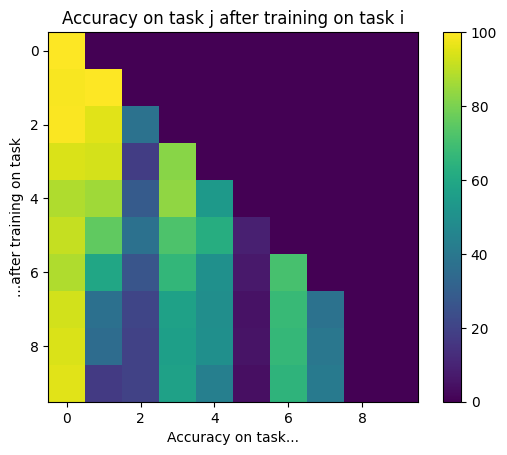

In [30]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix.png")
plt.show()

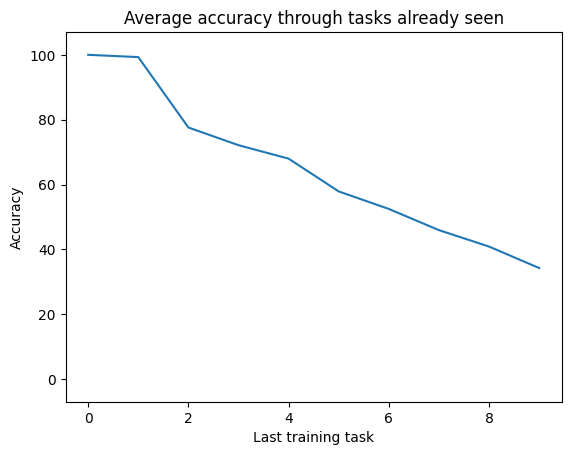

In [25]:
plt.plot(mean_test_accs_through_past_tasks)
plt.ylim(-7,107)
plt.ylabel("Accuracy")
plt.xlabel("Last training task")
plt.title("Average accuracy through tasks already seen")
plt.savefig("average_accuracy_through_tasks.png")
plt.show()

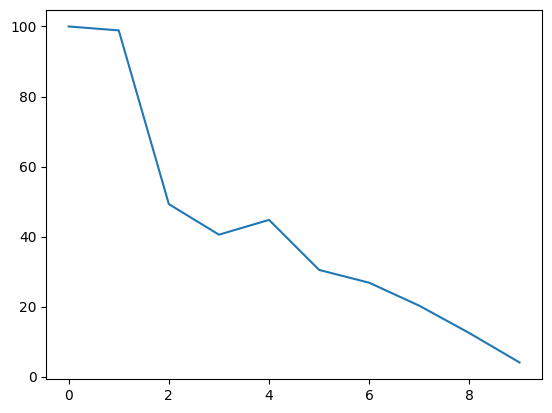

In [27]:
plt.plot(scores)
plt.show()

In [26]:
best_params

[{'lora_rank': 11,
  'alpha': 1.1614903414587885,
  'lr': 0.0002188622514413292,
  'num_epochs': 3},
 {'lora_rank': 8,
  'alpha': 1.407467128816199,
  'lr': 0.00011171410518375264,
  'num_epochs': 2},
 {'lora_rank': 11,
  'alpha': 0.7425252414673139,
  'lr': 7.102570236306082e-05,
  'num_epochs': 4},
 {'lora_rank': 14,
  'alpha': 0.5044982893038811,
  'lr': 9.35121030351349e-05,
  'num_epochs': 3},
 {'lora_rank': 14,
  'alpha': 0.8549307362565606,
  'lr': 6.136099248754296e-05,
  'num_epochs': 3},
 {'lora_rank': 14,
  'alpha': 1.3456268756020462,
  'lr': 7.387240671951386e-05,
  'num_epochs': 2},
 {'lora_rank': 16,
  'alpha': 1.6426525020762197,
  'lr': 0.00011549582612068879,
  'num_epochs': 1},
 {'lora_rank': 10,
  'alpha': 0.750643194036689,
  'lr': 1.2823075942257637e-05,
  'num_epochs': 3},
 {'lora_rank': 12,
  'alpha': 1.948787980576488,
  'lr': 1.3264085268678728e-05,
  'num_epochs': 4}]

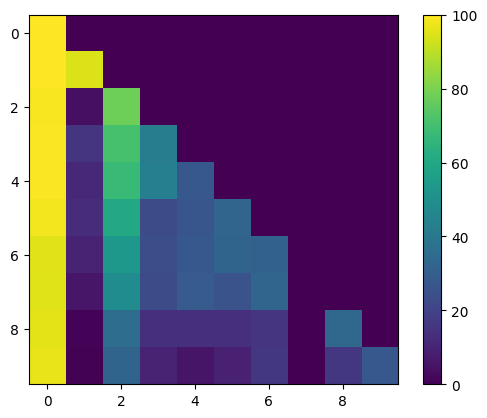

In [18]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to show the scale
plt.show()

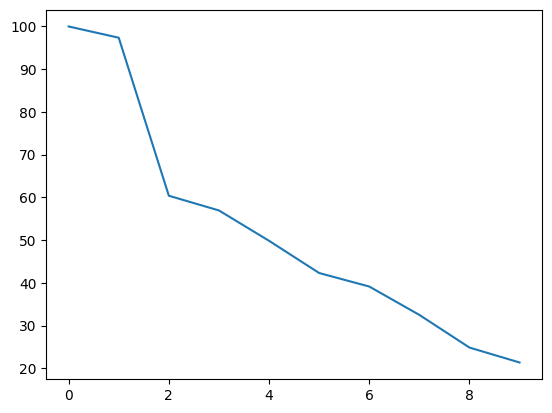

In [19]:
plt.plot(mean_test_accs_through_past_tasks)
plt.show()

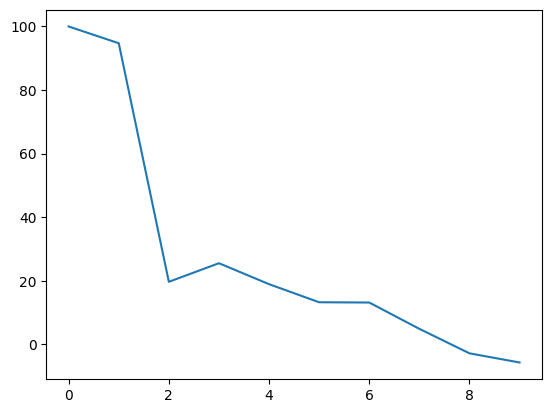

In [20]:
plt.plot(scores)
plt.show()

In [21]:
best_params

[{'lora_rank': 6,
  'alpha': 1.5673062420705972,
  'lr': 8.216664454330973e-05,
  'num_epochs': 4},
 {'lora_rank': 6,
  'alpha': 1.9353577648374949,
  'lr': 9.10667644777254e-05,
  'num_epochs': 3},
 {'lora_rank': 7,
  'alpha': 1.5261050576205688,
  'lr': 4.471246469282154e-05,
  'num_epochs': 4},
 {'lora_rank': 5,
  'alpha': 1.5886974930764635,
  'lr': 7.91648314717298e-05,
  'num_epochs': 3},
 {'lora_rank': 6,
  'alpha': 1.4662426113450853,
  'lr': 5.87099146575886e-05,
  'num_epochs': 4},
 {'lora_rank': 8,
  'alpha': 1.9959070844269116,
  'lr': 7.65841482399924e-05,
  'num_epochs': 2},
 {'lora_rank': 8,
  'alpha': 1.8987499159542107,
  'lr': 3.1668248328541624e-05,
  'num_epochs': 3},
 {'lora_rank': 3,
  'alpha': 1.8129520283696745,
  'lr': 6.039795659128214e-05,
  'num_epochs': 3},
 {'lora_rank': 7,
  'alpha': 1.3963682074961445,
  'lr': 8.731487007806618e-05,
  'num_epochs': 2}]